In [2]:
# math
import numpy as np
import math
import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
import edens as ed

# oparating system and times
import os
import time as ti

# better resources usage
import multiprocessing
# import numba as nb

# simulation file reading
import h5py 
import gizmo_analysis as gizmo
import halo_analysis as halo
import utilities as ut

# visuals
from PIL import Image
import ipywidgets as wg
from matplotlib.colors import Normalize
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

#interpolation
from scipy.interpolate import griddata

## Different settings per analysis

In [3]:
simulation_galaxy = "m12i_res7100"
# simulation_galaxy = "m11d_res7100"
simulation_directory = "Sims/" + simulation_galaxy
# simulation_directory = "Sims/" + simulation_galaxy
species_name = 'gas' # Which particle type I am interest in
host_name = ut.catalog.get_host_name(0) # in case there is more than 1 galaxy you can choose the host
print(host_name)
output_directory = "output/"

# parameters for HI_column_density analysis
box_size = 35 # box size of particles around the galaxy in kpc
T = 18 # temperature of which only particles under it would be considered (not activated now)
N = 250 # the number of bins per dimension (so N^2 bins in total) 

host.


## Relevant Properties/Calculations of particles

In [6]:
particles = gizmo.io.Read.read_snapshots("all",'redshift',0,simulation_directory,assign_hosts_rotation=True)
print(particles.Snapshot.keys())
print(particles.keys())


# in utilities.simulation.Snapshot():
* reading:  Sims/m12i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Sims/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  Sims/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal axes) from:  Sims/m12i_res710

## Basic particles properties, such as centered and aligned postions, velocity, density and temperature

In [ ]:
h = ds.cosmology.hubble_constant.value
main_halo_index = hal['host.index'][0]
main_halo_center = np.array(hal['position'][main_halo_index]*h) #in kpc
main_halo_virial_radius = hal['radius'][main_halo_index]

In [25]:
# obtaining particles numbering
part = particles
h = part.Cosmology['hubble']
# part_indices = ut.array.get_arange(part[species_name]['position'].shape[0])
part_indices = ut.array.get_arange(part['star']['position'].shape[0])
print(part['star'].keys())

# gas particles, centered and aligned to principal axes
# centered_gas_position = part[species_name].prop(f'{host_name}.distance.principal', part_indices)
# centered_gas_position = part[species_name]['position']
# centered_gas_velocity = part[species_name].prop(f'{host_name}.velocity.principal',part_indices)

# gas_density = part['gas']['density']
# gas_temperature = part['gas']['temperature']
# centered_gas_position_distances = part['gas'].prop('host.distance.total')
# cylindrical_centered_gas_position = part['gas'].prop('host.distance.principal.cylindrical')
center = part.host['position']*h
r = part['star'].prop(f'{host_name}.distance',part_indices) -center
v = part['star'].prop(f'{host_name}.velocity',part_indices)
m = part['star']['mass']
print(r)
print(v)
print(m)
L, L_size, L_disk = ed.calc_angular_momentum(m=m,r=r,v=v)
L_disk_norm = L_disk/np.linalg.norm(L_disk)
print(L_disk_norm)
NHI = part['gas'].prop('number.density')
# print(part.Cosmology)

dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity'])
[[ -4362.97746874 -41772.92863417 -44815.03029127]
 [-25354.54269905 -30954.72667432 -30225.96768943]
 [-24552.27952163 -29955.81819828 -30179.46120456]
 ...
 [-30249.66324868 -33272.72654373 -32744.33969026]
 [-30379.09074316 -33388.34602901 -32915.75213862]
 [-30366.86370502 -33421.90160458 -32874.89922459]]
[[ 2708.6611   -1168.3657   -1409.408   ]
 [ 2490.2612      15.731502  1405.7844  ]
 [  718.12427    -59.86928    321.21204 ]
 ...
 [  -60.85885   -189.98885    -42.000576]
 [  -76.93911   -213.76904    -58.575485]
 [  -75.55575   -217.20938    -55.19982 ]]
[ 6320.636  12393.744   4689.9375 ...  5306.1577  5434.9014  5381.738 ]
[ 0.42152094  0.43941986 -0.79324037]


In [16]:
print(part.host['position'])
print(part.host['velocity'])
print(part.host['rotation'])
print(part.host['axis.ratios'])

[[41792.15  44131.234 46267.68 ]]
[[-52.163765  73.55613   94.65796 ]]
[[[-0.14789672 -0.9403196   0.30647293]
  [-0.8559442   0.27694073  0.4366501 ]
  [-0.4954655  -0.19774461 -0.8458197 ]]]
[[0.15755726 0.15988114 0.98546493]]


### Filtering particles

In [5]:
num_part = len(part_indices)
def filter(R,T,N):

    # Filter particles by radius and temperature
    mask = (centered_gas_position_distances < R) & (gas_temperature < T) 

    if N < num_part:
        # Selecting N random particles after filtering 
        selected_indices = np.random.choice(np.where(mask)[0], size=N, replace=False)
        selected_particles_positions = centered_gas_position[selected_indices]
        x = selected_particles_positions[:,0]
        y = selected_particles_positions[:,1]
        z = selected_particles_positions[:,2]
    else:
        selected_indices = part_indices
        x = centered_gas_position[:,0][mask] # Only the positions of particles who are filtered
        y = centered_gas_position[:,1][mask]
        z = centered_gas_position[:,2][mask]
        
    
    # Selecting N particles in random with no filter
    # selected_indices = np.random.choice(centered_gas_position.shape[0], size=N, replace=False)
    
    # selecting only the selected particles
    # selected_particles_positions = centered_gas_position[selected_indices]
    # selected_particles_V = centered_gas_velocity[selected_indices] # Velocity
    # selected_particles_T = gas_temperature[selected_indices] # Temperature
    # selected_particles_log_T = np.log10(gas_temperature[selected_indices])
    # selected_particles_angular_momentum = np.cross(selected_particles_positions,selected_particles_V)
    # selected_particles_abs_angular_momentum = np.linalg.norm(selected_particles_angular_momentum, axis=1)
    # selected_particles_log_density=np.log10(gas_density[selected_indices])
    
    # print(selected_particles_log_T)
    # print(log_selected_particles_density)
    # print(abs_angular_momentum)
    return x,y,z,selected_indices
x ,y, z, selected_indices = filter(30,10e6,num_part)

## plotting the particles in 3D

### Plot the particles in 3D interactevly 

#### by angular momentum 

interactive(children=(IntSlider(value=5, description='R', min=5, step=5), IntSlider(value=3, description='T', …

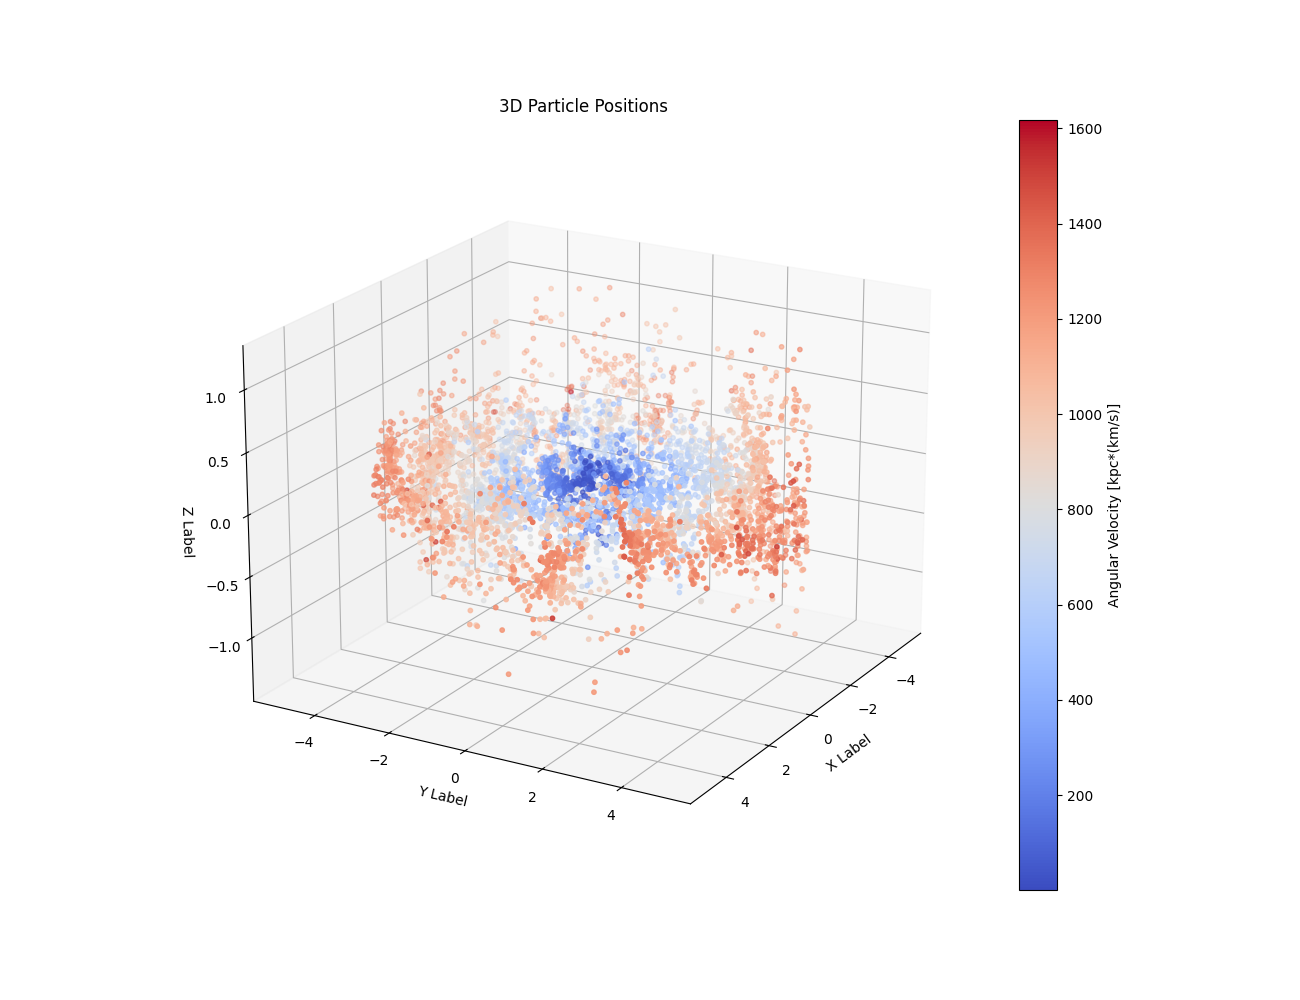

In [31]:
def update(R,T,N):

    T = np.power(10,T)
    # Obtaining x y and z positions of the filtered particles 
    x,y,z, selected_indices = filter(R,T,N)
    selected_particles_positions = centered_gas_position[selected_indices]
    selected_particles_V = centered_gas_velocity[selected_indices] # Velocity
    selected_particles_angular_momentum = np.cross(selected_particles_positions,selected_particles_V)
    selected_particles_abs_angular_momentum = np.linalg.norm(selected_particles_angular_momentum, axis=1)
    
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111,projection='3d')
    scatter = ax.scatter(x, y, z, marker='o',c=selected_particles_abs_angular_momentum,cmap='coolwarm',s=10, label='Particles')
    
    # Enable interactive mode
    %matplotlib widget
    
    # Customize the color mapping according to angular velocities
    cbar = plt.colorbar(scatter)
    cbar.set_label('Angular Velocity [kpc*(km/s)]')
    
    # You can customize the plot with labels, titles, etc.
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Particle Positions')
    ax.view_init(elev=20, azim=30)
    plt.show()

R_silde = wg.IntSlider(value=5,min=5,max=100,step=5)
T_slide = wg.IntSlider(value=3,min=3,max=10,step=1)
N_slide = wg.IntSlider(value=5000,min=5000,max=200000,step=5000)
wg.interact(update,R=R_silde,T=T_slide,N=N_slide)

plt.show()

#### by log density [Msun / kpc^3]

interactive(children=(IntSlider(value=5, description='R', min=5, step=5), IntSlider(value=3, description='T', …

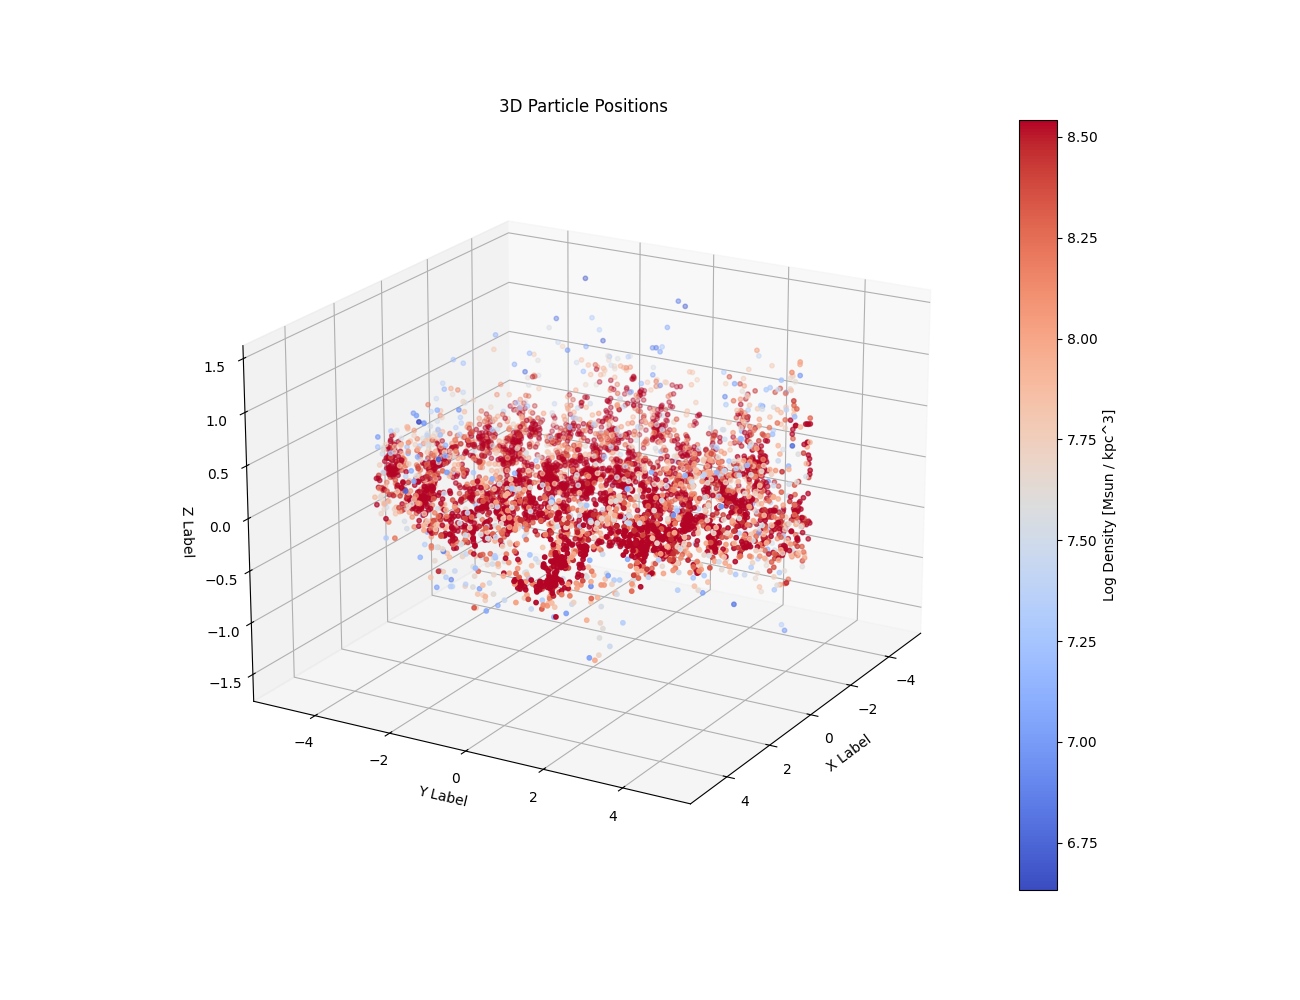

In [8]:
def update(R,T,N):

    T = np.power(10,T)
    # Obtaining x y and z positions of the filtered particles 
    x,y,z, selected_indices = filter(R,T,N)
    selected_particles_log_density = np.log10(gas_density[selected_indices])
    
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111,projection='3d')
    norm = Normalize(np.min(selected_particles_log_density),np.mean(selected_particles_log_density))
    scatter = ax.scatter(x, y, z, marker='o',c=selected_particles_log_density,cmap='coolwarm',s=10, label='Particles',norm=norm)
    
    # Enable interactive mode
    %matplotlib widget
    
    # Customize the color mapping according to density
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log Density [Msun / kpc^3]')
    
    # You can customize the plot with labels, titles, etc.
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Particle Positions')
    ax.view_init(elev=20, azim=30)
    plt.show()

R_silde = wg.IntSlider(value=5,min=5,max=100,step=5)
T_slide = wg.IntSlider(value=3,min=3,max=10,step=1)
N_slide = wg.IntSlider(value=5000,min=5000,max=200000,step=5000)
wg.interact(update,R=R_silde,T=T_slide,N=N_slide)

plt.show()

#### by log Temerature [K] using matplotlib

In [22]:
def update(R,T,N):
    
    T = np.power(10,T)
    # Obtaining x y and z positions of the filtered particles 
    x,y,z, selected_indices = filter(R,T,N)
    selected_particles_log_T = np.log10(gas_temperature[selected_indices])

    
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111,projection='3d')
    norm = Normalize(np.min(selected_particles_log_T),np.mean(selected_particles_log_T))
    scatter = ax.scatter(x, y, z, marker='o',c=selected_particles_log_T,cmap='coolwarm',s=5, label='Particles',vmin=np.min(selected_particles_log_T),vmax=np.max(selected_particles_log_T))
    # Enable interactive mode
    # %matplotlib notebook
    %matplotlib widget
    # %matplotlib inline
    
    # Customize the color mapping according to temerature [K]
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log Temperature [K]')
    
    # Plotting the velocity vectors
    # ax.quiver(x, y, z, selected_particles_V[:,0], selected_particles_V[:,1], selected_particles_V[:,2], length=2, normalize=True, color='g', label='Velocity Vectors')
    
    # You can customize the plot with labels, titles, etc.
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Particle Positions')
    ax.view_init(elev=20, azim=30)
    plt.show()

R_silde = wg.IntSlider(value=5,min=5,max=100,step=5)
T_slide = wg.IntSlider(value=3,min=3,max=10,step=1)
N_slide = wg.IntSlider(value=5000,min=5000,max=200000,step=5000)
wg.interact(update,R=R_silde,T=T_slide,N=N_slide)

# plt.legend()
plt.show()

interactive(children=(IntSlider(value=5, description='R', min=5, step=5), IntSlider(value=3, description='T', …

#### by Temerature [K]

NameError: name 'selected_particles_T' is not defined

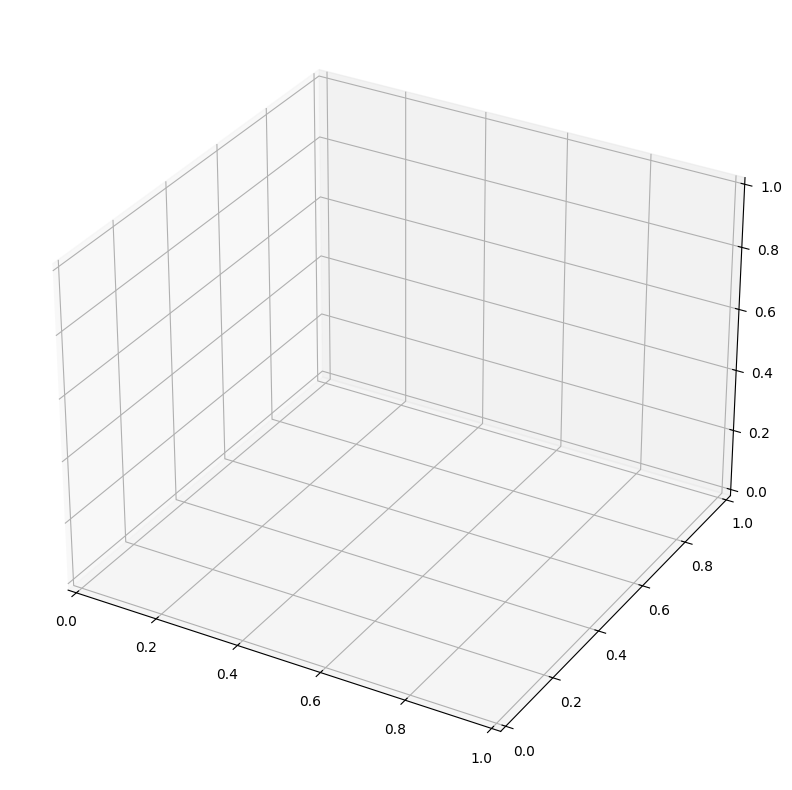

In [26]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111,projection='3d')
scatter = ax.scatter(x, y, z, marker='o',c=selected_particles_T,cmap='coolwarm',s=10, label='Particles')

# Enable interactive mode
# %matplotlib notebook
%matplotlib widget
# %matplotlib inline

# Customize the color mapping according to temerature [K]
cbar = plt.colorbar(scatter)
cbar.set_label('Temperature [K]')

# You can customize the plot with labels, titles, etc.
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Particle Positions')
ax.view_init(elev=20, azim=30)
plt.show()

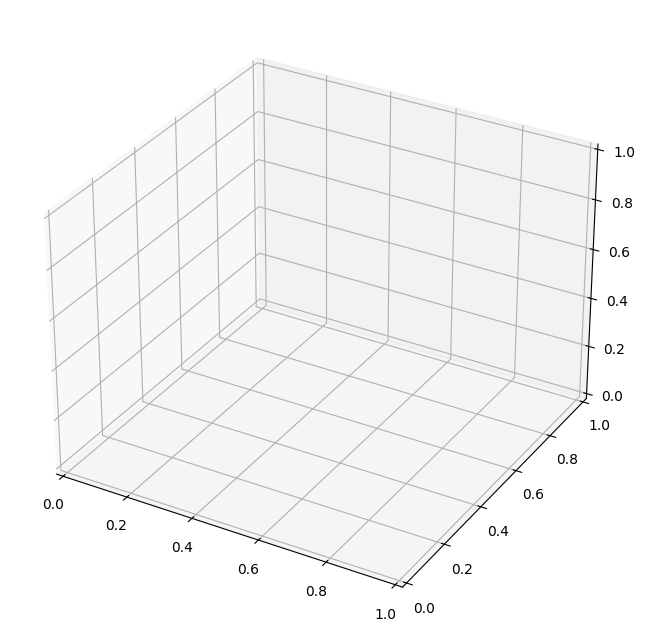

interactive(children=(FloatSlider(value=0.0, description='theta', max=360.0, step=5.0), Output()), _dom_classe…

In [25]:
  # Set the elevation and azimuthal angles as needed

def update(theta):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111,projection='3d')
    # ax.scatter(x, y, z, marker='o',c=abs_angular_momentum,cmap='viridis',s=10, label='Particles')
    ax.scatter(x, y, z, marker='o',c=log_selected_particles_density,cmap='coolwarm',s=10, label='Particles',vmin=2,vmax=5)
    
    # Enable interactive mode
    # %matplotlib notebook
    # %matplotlib widget
    %matplotlib inline
    
    # Customize the color mapping according to angular velocities
    # cbar = plt.colorbar(scatter)
    # cbar.set_label('Angular Velocity')
    
    # You can customize the plot with labels, titles, etc.
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Particle Positions')
    ax.view_init(elev=10, azim=theta)

theta_silde = wg.FloatSlider(valua=0,min=0,max=360,step=5)

wg.interact(update,theta=theta_silde)

# plt.legend()
plt.show()

## Face-on OR Edge-on integration and plotting

### Boxed Face-on integration

In [25]:
def boxed_HI_FaceOn_LOS_intagartion(x,y,diff,n,box_size):
    """
    Gets the bottom left coordinate and the difference to the other coordinate to define the bin [(x,y),(x+diff,y),(x,y+diff),(x+diff,y+diff)] and return the HI columns density of particles in that bin

    Parameters:
    x (float): the x coordinate of the bottom left point of the bin
    y (float): the y coordinate of the bottom left point of the bin
    diff (float): the difference to the next point of the bin
    part (list): the particles list that we are interested in (for example only gas particles with temperature lower than 10e4 [K])

    Returns:
    float: the HI column density of the bin [cm^-2]
    """
    # print("started with number: " + str(n))
    # mask = (gas_temperature < T)
    mask  = (centered_gas_position[:,0] <= box_size) & (centered_gas_position[:,0] >= -box_size) 
    mask *= (centered_gas_position[:,1] <= box_size) & (centered_gas_position[:,1] >= -box_size)
    # mask *= (centered_gas_position[:,2] <= box_size) & (centered_gas_position[:,2] >= -box_size)
    mask *= (centered_gas_position[:,0] >= x)
    mask *= (centered_gas_position[:,0] < x+diff)
    mask *= (centered_gas_position[:,1] >= y)
    mask *= (centered_gas_position[:,1] < y+diff)

    gas_postions_in_bin = centered_gas_position[mask] # apply the filter
    z_coordiantes = gas_postions_in_bin[:,2] # The z coordinates of the gas particles in the bin 
    sorted_indices = np.argsort(z_coordiantes)
    sorted_HI_number_density = NHI[mask][sorted_indices]
    sorted_z_gas_postions_in_bin = z_coordiantes[sorted_indices]
    HI_column_density = 0 # [cm^-2]
    # print("first: " + str(sorted_z_gas_postions_in_bin[0]) + " and second: " + str(sorted_z_gas_postions_in_bin[1]) + " and third: " + str(sorted_z_gas_postions_in_bin[2]) + " ")
    
    #intagrating on LOS in bin
    for i in range(len(sorted_z_gas_postions_in_bin)-1): 
        HI_column_density += (((np.abs(sorted_z_gas_postions_in_bin[i+1]-sorted_z_gas_postions_in_bin[i])*u.kpc).to(u.cm))*sorted_HI_number_density[i]).value
  
    if HI_column_density != 0:
        return np.log10(HI_column_density)
    else: return 0

### Radial Face-on integration

In [26]:
def radial_HI_FaceOn_LOS_intagartion(phi,dphi,n,r,dr):
    """
    Gets the bottom left coordinate and the difference to the other coordinate to define the bin [(x,y),(x+diff,y),(x,y+diff),(x+diff,y+diff)] and return the HI columns density of particles in that bin

    Parameters:
    x (float): the x coordinate of the bottom left point of the bin
    y (float): the y coordinate of the bottom left point of the bin
    diff (float): the difference to the next point of the bin
    part (list): the particles list that we are interested in (for example only gas particles with temperature lower than 10e4 [K])

    Returns:
    float: the HI column density of the bin [cm^-2]
    """
    # print("started with number: " + str(n))
    # mask = (gas_temperature < T)
    mask = (cylindrical_centered_gas_position[:,0] >= r ) & ( cylindrical_centered_gas_position[:,0] < r+dr)
    mask *= (cylindrical_centered_gas_position[:,1] >= phi ) & ( cylindrical_centered_gas_position[:,1] < phi+dphi)

    gas_postions_in_bin = cylindrical_centered_gas_position[mask] # apply the filter
    z_coordiantes = gas_postions_in_bin[:,2] # The z coordinates of the gas particles in the bin 
    sorted_indices = np.argsort(z_coordiantes)
    gas_HI_number_density_in_bin = NHI[mask]
    sorted_HI_number_density = gas_HI_number_density_in_bin[sorted_indices]
    sorted_z_gas_postions_in_bin = z_coordiantes[sorted_indices]
    HI_column_density = 0 # [cm^-2]

    #intagrating on LOS in bin
    for i in range(len(sorted_z_gas_postions_in_bin)-1): 
        HI_column_density += (((np.abs(sorted_z_gas_postions_in_bin[i+1]-sorted_z_gas_postions_in_bin[i])*u.kpc).to(u.cm))*sorted_HI_number_density[i]).value
  
    return HI_column_density

### Boxed Edge-on integration

In [27]:
def boxed_HI_EdgeOn_LOS_intagartion(x,z,diff,n,box_size):
    """
    Gets the bottom left coordinate and the difference to the other coordinate to define the bin [(x,z),(x+diff,z),(x,z+diff),(x+diff,z+diff)] and return the HI columns densitz of particles in that bin

    Parameters:
    x (float): the x coordinate of the bottom left point of the bin
    z (float): the y coordinate of the bottom left point of the bin
    diff (float): the difference to the next point of the bin
    part (list): the particles list that we are interested in (for example only gas particles with temperature lower than 10e4 [K])

    Returns:
    float: the HI column density of the bin [cm^-2]
    """

    # mask = (gas_temperature < T)
    mask  = (centered_gas_position[:,0] <= box_size) & (centered_gas_position[:,0] >= -box_size) # Boxing in the x direction
    # mask *= (centered_gas_position[:,1] <= box_size) & (centered_gas_position[:,1] >= -box_size)
    mask *= (centered_gas_position[:,2] <= box_size) & (centered_gas_position[:,2] >= -box_size) # boxing in the y direction
    mask *= (centered_gas_position[:,0] >= x) # applying masks to filter particles outside of column
    mask *= (centered_gas_position[:,0] < x+diff)
    mask *= (centered_gas_position[:,2] >= z)
    mask *= (centered_gas_position[:,2] < z+diff)

    gas_postions_in_bin = centered_gas_position[mask] # apply the filter
    y_coordiantes = gas_postions_in_bin[:,1] # The y coordinates of the gas particles in the bin 
    sorted_indices = np.argsort(y_coordiantes)
    sorted_HI_number_density = NHI[mask][sorted_indices]
    sorted_y_gas_postions_in_bin = y_coordiantes[sorted_indices]
    HI_column_density = 0 # [cm^-2]
    
    #intagrating on LOS in bin
    for i in range(len(sorted_y_gas_postions_in_bin)-1): 
        HI_column_density += (((np.abs(sorted_y_gas_postions_in_bin[i+1]-sorted_y_gas_postions_in_bin[i])*u.kpc).to(u.cm))*sorted_HI_number_density[i]).value
  
    if HI_column_density != 0:
        return np.log10(HI_column_density)
    else: return 0

## Boxed Face-on plotting

6.490581417083741
minutes long!
had zeros
number of interpolations: 524


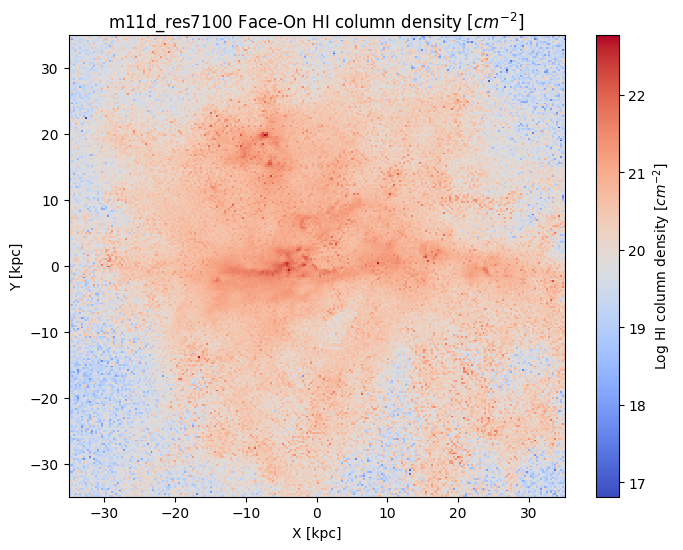

CPU times: user 12.2 s, sys: 1.21 s, total: 13.4 s
Wall time: 6min 32s


In [35]:
%%time
# N = 250
# box_size = 54
direction = "Face-On"
# T = np.power(10,T) # [K]

# Filter particles by box size and temperature
mask  = (centered_gas_position[:,0] <= box_size) & (centered_gas_position[:,0] >= -box_size) 
mask *= (centered_gas_position[:,1] <= box_size) & (centered_gas_position[:,1] >= -box_size)
# mask *= (centered_gas_position[:,2] <= box_size) & (centered_gas_position[:,2] >= -box_size)
# mask *= gas_temperature <= T
x = centered_gas_position[:,0][mask] # Only the positions of particles who are filtered
y = centered_gas_position[:,1][mask]

# Define the number of bins in the x and y directions
num_bins_x = num_bins_y = num_bins_z = N

# Compute bin edges
x_edges = np.linspace(min(x), max(x), num=num_bins_x + 1)
y_edges = np.linspace(min(y), max(y), num=num_bins_y + 1)

diff = x_edges[1]-x_edges[0]
args = [(x_edges[i],y_edges[j],diff,i+j*N,box_size) for j in range(N) for i in range(N)] # List of arguments for parallel computing
# for k in range(1000):
#     print(args[k])

# Create a 2D histogram with custom values
HI_column_densities = [] # bin values for 2D graph


# split the integration into all the cores
if __name__ == '__main__':
    start_time = ti.time()
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.starmap(boxed_HI_FaceOn_LOS_intagartion, args)
        for HI_column_density in results:
            HI_column_densities.append(HI_column_density)
        HI_column_densities = np.array(HI_column_densities).reshape(N,N)
        end_time = ti.time()
        print((end_time-start_time)/60)
        print("minutes long!")
        
# Save the histogram with the informative name
# filename = "HI_cloumn_denities_" + simulation_galaxy + "_" + direction + "_" + str(N) + "_" + str(box_size) + "_" + str(int(np.log10(T)))
filename = "HI_column_densities_" + simulation_galaxy + "_" + direction + "_N" + str(N) + "_B" + str(box_size)
np.save(output_directory + filename,HI_column_densities)

# interpolation for zeros fixes
has_zeros = np.any(HI_column_densities == 0)
if has_zeros:
    print("had zeros")
    HI_column_densities,count = cubic_interpolate(HI_column_densities)
    print("number of interpolations: " + str(count))

# Plot the 2D histogram with bin boundaries
plt.figure(figsize=(8, 6))
plt.imshow(HI_column_densities, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='coolwarm', origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar(label=r'Log HI column density [$cm^{-2}$]')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title(simulation_galaxy + r' Face-On HI column density [$cm^{-2}$]')
plt.savefig(output_directory + simulation_galaxy + " " + direction + " N" + str(N) + " B" + str(box_size) + r' HI column density' + '.png', dpi=300, bbox_inches='tight') 
plt.show()

## Boxed Edge-on plotting

6.514906287193298
minutes long!
had zeros
number of interpolations: 1756


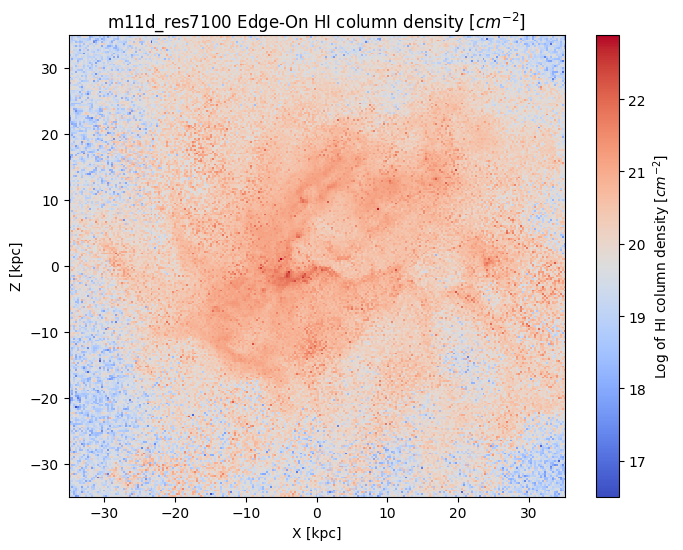

CPU times: user 12.2 s, sys: 1.17 s, total: 13.4 s
Wall time: 6min 33s


In [36]:
%%time
# N = 250
# box_size = 35
direction = "Edge-On"

# T = np.power(10,T)

# Filter particles by box size [kpc] and temperature [K]
mask  = (centered_gas_position[:,0] <= box_size) & (centered_gas_position[:,0] >= -box_size) 
# mask *= (centered_gas_position[:,1] <= box_size) & (centered_gas_position[:,1] >= -box_size)
mask *= (centered_gas_position[:,2] <= box_size) & (centered_gas_position[:,2] >= -box_size)
# mask *= gas_temperature <= T # adds another filter for temperature limit
x = centered_gas_position[:,0][mask] # Only the positions of particles who are filtered
z = centered_gas_position[:,2][mask]

# Define the number of bins in the x and z directions
num_bins_x = num_bins_y = num_bins_z = N

# Compute bin edges
x_edges = np.linspace(min(x), max(x), num=num_bins_x + 1)
z_edges = np.linspace(min(z), max(z), num=num_bins_z + 1)

diff = x_edges[1]-x_edges[0] # used to filter particles to inside the bin only
args = [(x_edges[i],z_edges[j],diff,j+i*N,box_size) for j in range(N) for i in range(N)] # List of arguments for parallel computing

# Create a 2D histogram with custom values
HI_column_densities = [] # bin values for 2D graph

# split the integration into all the cores
if __name__ == '__main__':
    start_time = ti.time()
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.starmap(boxed_HI_EdgeOn_LOS_intagartion, args)
        for HI_column_density in results:
            HI_column_densities.append(HI_column_density)
        HI_column_densities = np.array(HI_column_densities).reshape(N,N)
        end_time = ti.time()
        print((end_time-start_time)/60)
        print("minutes long!")
        
# Save the histogram with the informative name
filename = "HI_column_densities_" + simulation_galaxy + "_" + direction + "_N" + str(N) + "_B" + str(box_size) + ".npy"
np.save(output_directory + filename,HI_column_densities)

# interpolation for zeros fixes
has_zeros = np.any(HI_column_densities == 0)
if has_zeros:
    print("had zeros")
    HI_column_densities,count = cubic_interpolate(HI_column_densities)
    print("number of interpolations: " + str(count))
    

# Plot the 2D histogram with bin boundaries
plt.figure(figsize=(8, 6)) 
plt.imshow(HI_column_densities, extent=[x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]],
           cmap='coolwarm', origin='lower', aspect='auto', interpolation='none')
plt.colorbar(label=r'Log of HI column density [$cm^{-2}$]')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')
plt.title(simulation_galaxy + r' Edge-On HI column density [$cm^{-2}$]')
plt.savefig(output_directory + simulation_galaxy + " " + direction + " N" + str(N) + " B" + str(box_size) + r' HI column density' + '.png', dpi=300, bbox_inches='tight') 
plt.show()

### interpolation of zeros and plotting in case where I had empty bins.

In [9]:
def cubic_interpolate(data):
    count = 0
    for k in range(len(HI_column_densities)):
        for j in range(len(HI_column_densities[k])):
            if HI_column_densities[k][j] == 0:
                count += 1
    zero_mask = (data == 0)

    # Create a grid of coordinates for the entire matrix
    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    
    # Flatten the grid and the array while excluding zero values using the zero_mask
    x_flat = x[~zero_mask].flatten()
    y_flat = y[~zero_mask].flatten()
    values_flat = data[~zero_mask].flatten()
    
    # Perform interpolation using griddata
    data = griddata((x_flat, y_flat), values_flat, (x, y), method='cubic')
    return data, count

had zeros
number of interpolations: 38


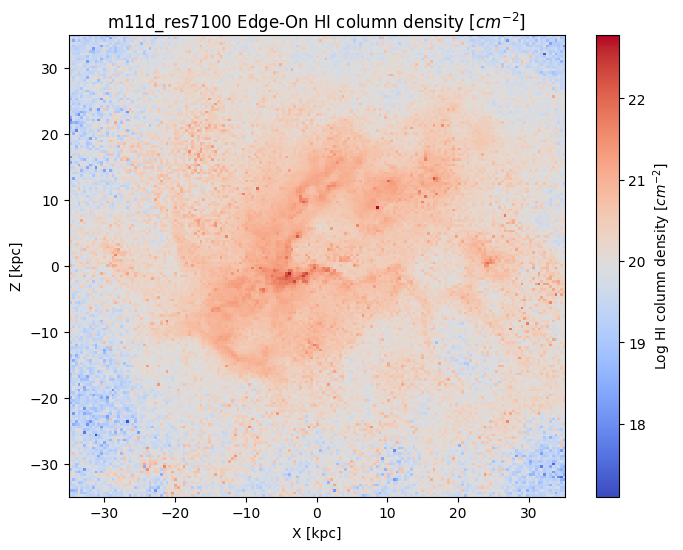

In [33]:
# direction = "Face-On"
direction = "Edge-On"
# N = 250
# box_size = 35

# Filter particles by box size [kpc] and temperature [K]
mask  = (centered_gas_position[:,0] <= box_size) & (centered_gas_position[:,0] >= -box_size) 
mask *= (centered_gas_position[:,1] <= box_size) & (centered_gas_position[:,1] >= -box_size)
mask *= (centered_gas_position[:,2] <= box_size) & (centered_gas_position[:,2] >= -box_size)
# mask *= gas_temperature <= T # adds another filter for temperature limit
x = centered_gas_position[:,0][mask] # Only the positions of particles who are filtered
y = centered_gas_position[:,0][mask]
z = centered_gas_position[:,2][mask]

x_edges = np.linspace(min(x), max(x), num=num_bins_x + 1)
y_edges = np.linspace(min(y), max(y), num=num_bins_z + 1)
z_edges = np.linspace(min(z), max(z), num=num_bins_z + 1)

filename = "HI_column_densities_" + simulation_galaxy + "_" + direction + "_N" + str(N) + "_B" + str(box_size) + ".npy"
HI_column_densities = np.load(output_directory + filename)
has_zeros = np.any(HI_column_densities == 0)
if has_zeros:
    print("had zeros")
    HI_column_densities,count = cubic_interpolate(HI_column_densities)
    print("number of interpolations: " + str(count))

# HI_column_densities = generic_filter(HI_column_densities, interpolate_zeros, size=3, mode='constant')
# Plot the 2D histogram with bin boundaries
plt.figure(figsize=(8, 6))

plt.xlabel('X [kpc]')
if direction == "Face-On":
    plt.ylabel('Y [kpc]')
    plt.imshow(HI_column_densities, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='coolwarm', origin='lower', aspect='auto', interpolation='nearest')
else: 
    plt.ylabel('Z [kpc]')
    plt.imshow(HI_column_densities, extent=[x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]],
           cmap='coolwarm', origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar(label=r'Log HI column density [$cm^{-2}$]')
plt.title(simulation_galaxy + " " + direction + r' HI column density [$cm^{-2}$]')
plt.savefig(output_directory + simulation_galaxy + " " + direction + " N" + str(N) + " B" + str(box_size) + r' HI column density' + '.png', dpi=300, bbox_inches='tight') 
plt.show()

## Averaging N_HI for each radius r=R and dr=dr

### get an interpolated matrix of the data on RAM so I wont comtaminate the analysis

In [ ]:
# choose the data
directions = ["Face-On","Edge-On"]
for direction in directions:
    N = 200
    box_size = 35
    
    # load data from memory
    filename = "HI_column_densities_" + simulation_galaxy + "_" + direction + "_N" + str(N) + "_B" + str(box_size) + ".npy"
    HI_column_densities = np.load(output_directory + filename)
    
    #interpolate if has zeros in it
    interpolated_HI_column_densities,count = cubic_interpolate(HI_column_densities)
    

In [ ]:
NR = 20
Nphi = 64
R = 35
box_size = 35
R0 = 0.1
direction = "Face-On"
# T = np.power(10,T) # [K]

# Filter particles by box size and temperature
mask = (cylindrical_centered_gas_position[:,0] <= R 
# mask *= gas_temperature <= T

# Define the number of bins in the x and y directions
num_bins_r = NR
dr = int(np.power(R,1/NR)/R0)
num_bins_phi = Nphi
dpi = 2*np.pi/Nphi

# Compute bin edges
# x_edges = np.linspace(min(x), max(x), num=num_bins_x + 1)
# y_edges = np.linspace(min(y), max(y), num=num_bins_y + 1)


Rs = [R0*dr**i for i in range(NR)]
phis = [dphi*i in range(Nphi)]

args = [(phis[j],dphi,i+j*N,Rs[i],dr) for j in range(Nphi) for i in range(NR)] # List of arguments for parallel computing
# for k in range(1000):
#     print(args[k])

# Create a 2D histogram with custom values
HI_column_densities = [] # bin values for 2D graph


# split the integration into all the cores
if __name__ == '__main__':
    start_time = ti.time()
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.starmap(boxed_HI_FaceOn_LOS_intagartion, args)
        for HI_column_density in results:
            HI_column_densities.append(HI_column_density)
        HI_column_densities = np.array(HI_column_densities).reshape(N,N)
        end_time = ti.time()
        print((end_time-start_time)/60)
        print("minutes long!")
        
# Save the histogram with the informative name
# filename = "HI_cloumn_denities_" + simulation_galaxy + "_" + direction + "_" + str(N) + "_" + str(box_size) + "_" + str(int(np.log10(T)))
filename = "HI_column_densities_" + simulation_galaxy + "_" + direction + "_N" + str(N) + "_B" + str(box_size)
np.save(output_directory + filename,HI_column_densities)

# interpolation for zeros fixes
if has_zeros:
    print("had zeros")
    HI_column_densities,count = cubic_interpolate(HI_column_densities)
    print("number of interpolations: " + str(count))

# Plot the 2D histogram with bin boundaries
plt.figure(figsize=(8, 6))
plt.imshow(HI_column_densities, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='coolwarm', origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar(label=r'Log HI column density [$cm^{-2}$]')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title(simulation_galaxy + r' Face-On HI column density [$cm^{-2}$]')
plt.show()

## Plotting a 1D Graph of average N_HI vs r